<a href="https://colab.research.google.com/github/tbonne/peds/blob/main/docs/introComm/IntroCausalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='http://drive.google.com/uc?export=view&id=1gfef2jOOS8IuF0L-2yYmx2D0eEEmZwQs' width=500>


***

## <font color='darkorange'>Explainability vs Causality</font>


Here we will look at the difference between understanding how the ML model is making predictions (explainability) and what is causing the outcome (causality)


To do so we will look at a silly example where we know that the patterns picked up by the model are not causal.


### <font color='darkorange'>Waffle houses and divorce rates</font>


In [ ]:
import pandas as pd
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Load the data

In [ ]:
#load data
df_waffles = pd.read_csv("/content/waffles.csv")

#take a look
df_waffles.head()

Visualize the data

In [ ]:
#sort the dataframe
pd_df = df_waffles.sort_values(['Divorce']).reset_index(drop=True)

#plot by state
sns.barplot(data=pd_df, x="Loc",y="Divorce")
plt.xticks(rotation=90)

### <font color='darkorange'>Do whaffle houses cause divorce?</font>


In [ ]:
#correlation
df_waffles.WaffleHouses.corr(df_waffles.Divorce)

In [ ]:
#scatter plot
sns.scatterplot(data=df_waffles, x="WaffleHouses", y="Divorce" )


Data wrangling

In [ ]:
#split these data into training and testing datasets
df_train, df_test = train_test_split(df_waffles, test_size=0.20, random_state=14)

### <font color='darkorange'>Build a model</font>

Can we predict divorce rates based on:
1. population
2. marage rates (more mariage more divorce)
3. Median age at marriage
4. Number of waffle houses

<img src='http://drive.google.com/uc?export=view&id=1WC4tXGCEF-1_2LQ74gIxJAZ-GLXCwBdK' width="100">  

Build a linear regression predicting Divorce using wafflehouses.

In [ ]:
import statsmodels.api as sm #for running regression!
import statsmodels.formula.api as smf

#Build the model
linear_reg_model = smf.ols(formula='Divorce ~ WaffleHouses ', data=df_train)

#Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_results = linear_reg_model.fit()

#summary
print(linear_reg_results.summary())

### <font color='darkorange'>Fit the model again, this time add the South variable</font>

In [ ]:
#Build the model
linear_reg_model_South = smf.ols(formula='Divorce ~ WaffleHouses + South', data=df_train)

#Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_model_South = linear_reg_model_South.fit()

#summary
print(linear_reg_model_South.summary())

#### <font color='darkorange'>Bonus</font>

Try to run the models with alternative combinations of variables? How does the model estimate of the effect of wafflehouses on divorce change?

### <font color='darkorange'>Statistical confounds</font>

> Statistical confounds make it hard to determine the causal nature of the patterns we find in ML model results. We need to be careful about how we explain how a model makes predictions and the causal nature of those patterns.

> In the case of the whaffle houses and divorce rates, there are just more waffle houses in southern states. South --> wafflehouses --> Divorce rates

In [ ]:
sns.boxplot(data=df_waffles, x="South", y="WaffleHouses")

### <font color='darkorange'>Let's see what feature importance suggests</font>

<img src='http://drive.google.com/uc?export=view&id=1WC4tXGCEF-1_2LQ74gIxJAZ-GLXCwBdK' width="100">  

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

#split data into predictors (X) and target (y)
X = df_waffles.drop(['Divorce','Location','Loc'],axis=1)
y = df_waffles['Divorce']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#fit linear regression
LR1 = LinearRegression()
LR1.fit(X_train, y_train)

#model interpretation
rel_impo = permutation_importance(LR1, X_test, y_test,n_repeats=30,random_state=0)
pd.DataFrame({"feature":X_test.columns,"importance":rel_impo.importances_mean, "sd":rel_impo.importances_std})

### <font color='darkorange'>Let's see what feature selection suggests</font>

In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

#split data into predictors (X) and target (y)
X = df_waffles.drop(['Divorce','Location','Loc'], axis=1)
y = df_waffles['Divorce']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#build a linear regression (full model)
LR1 = LinearRegression()

#fit linear regression
LR1.fit(X_train, y_train)

In [ ]:
#min number of variables/features
min_features_to_select = 1

#build the feature selection algorithm
rfecv = RFECV(estimator=LR1, step=1, cv=3,scoring='neg_mean_squared_error', min_features_to_select=min_features_to_select)

#fit the algorithm to the data
rfecv.fit(X_train, y_train)

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean square error?)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.support_

In [ ]:
X_train_reduced = X_train.iloc[:,rfecv.support_]

X_train_reduced.head(3)

In [ ]:
#get the slopes!
rfecv.estimator_.coef_

### <font color='darkorange'>Bonus</font>

Redo the exercise above this time using a more black box approach, e.g., Random Forest!

In [ ]:
from sklearn.model_selection import train_test_split

#split data into predictors (X) and target (y)
X = df_waffles[['Population','Marriage','WaffleHouses']]
y = df_waffles['Divorce']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Find optimal hyperparameters

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': list(range(1, 10,2)),
              'n_estimators':list(range(50,200,50)),
              'max_samples':[0.5,0.7,0.9,0.99]}

randForest = RandomForestRegressor()
grid_search = GridSearchCV(randForest, parameters, cv=5, n_jobs=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

sorted(grid_search.cv_results_.keys())
print(grid_search.best_params_)




{'max_depth': 5, 'max_samples': 0.99, 'n_estimators': 100}


Build the model with the optimal hyperparameters

In [ ]:
#1. build the model
RFR = RandomForestRegressor(max_depth=5,n_estimators=50,max_samples=0.5)

#2. fit the model to the data
RFR.fit(X_train, y_train)

#3. make predictions using the model
y_pred = RFR.predict(X_test)

How well did the model perform

In [ ]:
#how well does it predict
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred)

2.861558440608589

Explain how the model is making these predictions?

In [ ]:
#What is important for prediction?
from sklearn.inspection import permutation_importance

#estimate permutation importance on the test data
perm_impo = permutation_importance(RFR, X_test, y_test,scoring='neg_mean_squared_error',n_repeats=30)

#create a dataframe with the values
df_imp = pd.DataFrame({"feature":X_test.columns,"importance":perm_impo.importances_mean, "sd":perm_impo.importances_std})
sorted(sk.metrics.SCORERS.keys())

#take a look
df_imp

,feature,importance,sd
0,Population,0.358426,0.292075
1,Marriage,1.539061,0.902035
2,WaffleHouses,0.878724,0.643748


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

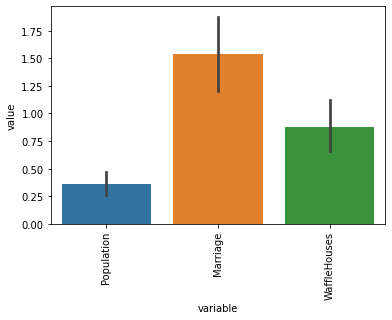

In [ ]:
#plot the importance values
df_imp_all = pd.DataFrame(perm_impo.importances.transpose())
df_imp_all.columns = X_test.columns
df_imp_all_long = pd.melt(df_imp_all)
sns.barplot(data=df_imp_all_long, x="variable",y="value", ci=95)
plt.xticks(rotation=90) 


What does the model think divorce rates will change when we vary wafflehouses?

array([ 9.828     ,  9.828     , 10.95209127, 11.50665238, 11.50865238,
       11.50865238, 11.50865238, 11.50865238, 11.50865238, 11.50865238,
       11.50865238, 11.50865238, 11.50865238, 11.50865238, 11.50865238,
       11.50865238, 11.50865238, 11.50865238, 11.50865238, 11.50865238])

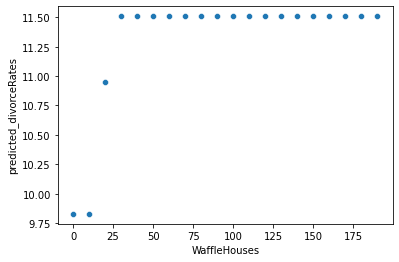

In [ ]:
#1. Create a dataframe
df_question = pd.DataFrame({'Population':X_train.Population.mean(),
                            'WaffleHouses':list(range(0,200,10)),
                            'Marriage':X_train.Marriage.mean(),
                            })
                            

#2. Use the model to make predictions
question_pred =  RFR.predict(df_question)

#3. add a column to the df_question
df_question['predicted_divorceRates'] = question_pred

#4. plot the predictions
sns.scatterplot(data=df_question, x='WaffleHouses',y='predicted_divorceRates')
question_pred

In my case, the random forest model has found a positive association between wafflehouses and divorce rates!

### Repeat the analysis but this time add in the variable 'South'


Data wrangling

In [ ]:
#split data into predictors (X) and target (y)
X = df_waffles[['Population','Marriage','WaffleHouses','South']]
y = df_waffles['Divorce']


#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Build the model

In [ ]:
RFR2 = RandomForestRegressor(max_depth=5,n_estimators=50,max_samples=0.5)
RFR2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Make predictions 

In [ ]:
mean_squared_error(RFR2.predict(X_test), y_test)

2.3490485825328804

In [ ]:
rel_impo2 = permutation_importance(RFR2, X_test, y_test,n_repeats=30,random_state=0)

pd.DataFrame({"feature":X_test.columns,"importance":rel_impo2.importances_mean, "sd":rel_impo2.importances_std})

,feature,importance,sd
0,Population,-0.014684,0.099183
1,Marriage,0.431683,0.246602
2,WaffleHouses,-0.122132,0.270624
3,South,-0.066082,0.031657


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

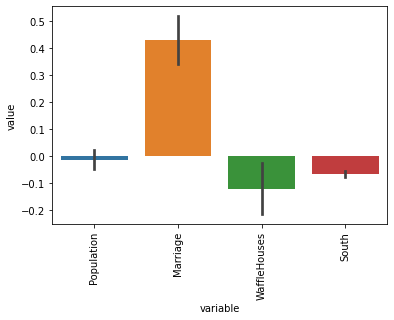

In [ ]:
df_imp_all = pd.DataFrame(rel_impo2.importances.transpose())
df_imp_all.columns = X_test.columns
df_imp_all_long = pd.melt(df_imp_all)
sns.barplot(data=df_imp_all_long, x="variable",y="value", ci=95)
plt.xticks(rotation=90)


What does the model think divorce rates will change when we vary wafflehouses?

array([10.04433333, 10.04433333, 10.68667857, 11.44525   , 11.44925   ,
       11.44925   , 11.44925   , 11.44925   , 11.44925   , 11.44925   ,
       11.44925   , 11.44925   , 11.44925   , 11.44925   , 11.44925   ,
       11.44925   , 11.44925   , 11.44925   , 11.44925   , 11.44925   ])

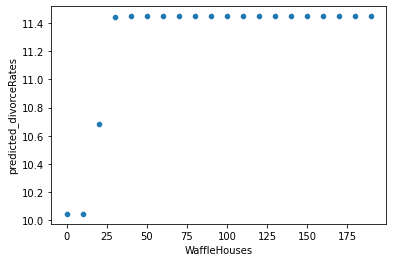

In [ ]:
#1. Create a dataframe
df_question = pd.DataFrame({'Population':X_train.Population.mean(),
                            'WaffleHouses':list(range(0,200,10)),
                            'Marriage':X_train.Marriage.mean(),
                            'South':1
                            })
                            

#2. Use the model to make predictions
question_pred =  RFR2.predict(df_question)

#3. add a column to the df_question
df_question['predicted_divorceRates'] = question_pred

#4. plot the predictions
sns.scatterplot(data=df_question, x='WaffleHouses',y='predicted_divorceRates')
question_pred

In this case, the random forest model has still found a positive association between wafflehouses and divorce rates!